In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Data Augmentation

This notebook shows how to perform data augmentation with Aucmedi.

## Downloading and preparing the data

First, the data need to be loaded and prepared for aucmedi.  
If you have questions concering that part, just have a look in the corresponding notebook.

In [2]:
from pathlib import Path
import wget
import zipfile

cwd = !pwd
datadir = cwd[0] + "/data"
Path(datadir).mkdir(parents=True, exist_ok=True)

#print('Beginning file download with wget module')

#url = 'https://zenodo.org/record/53169/files/Kather_texture_2016_image_tiles_5000.zip?download=1'
#wget.download(url, datadir)

#with zipfile.ZipFile("data/Kather_texture_2016_image_tiles_5000.zip","r") as zip_ref:
#    zip_ref.extractall("data")

from aucmedi.data_processing.io_data import input_interface
ds_loader = input_interface("directory", path_imagedir="data/Kather_texture_2016_image_tiles_5000", path_data=None, training=True, ohe=False)
(samples, class_ohe, nclasses, class_names, image_format) = ds_loader

from aucmedi.sampling.split import sampling_split

# We are working on only 13% of all data in order to make use of data-augmentation.

samples, _ = sampling_split(samples, class_ohe, sampling=[0.13, 0.87], 
                                         stratified=True, iterative=False, seed=123)

train, validation, test = sampling_split(samples[0], samples[1], sampling=[0.5, 0.25, 0.25], 
                                         stratified=True, iterative=False, seed=123)

2022-08-17 17:31:02.520861: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Define the augmentation model

Now we define our NeuralNetwork. If you have questions concering that, have a look in the notebook "Custom Architecture" or "3 Pillars".  

In [3]:
from aucmedi.neural_network.model import NeuralNetwork
import tensorflow.keras as tfa

f1Score = tfa.metrics.F1Score(num_classes=nclasses, threshold=0.5)

augmentation_model = NeuralNetwork(n_labels=nclasses, channels=3, loss="categorical_crossentropy", metrics=["categorical_accuracy", f1Score], activation_output="softmax")

2022-08-17 17:31:05.751309: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-17 17:31:06.313823: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22844 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:3f:00.0, compute capability: 7.5


## Define the Image Augmentation

Now we are going to define the Image Augmentation object. Here we are using the default parameters (by just calling ``ImageAugmentation()`` with empty brackets).  
But we could also specify how the images should be augmented by [setting parameters to True or False](https://frankkramer-lab.github.io/aucmedi/reference/data_processing/augmentation/aug_image/#aucmedi.data_processing.augmentation.aug_image).

In [4]:
from aucmedi.ensemble.augmenting import ImageAugmentation 
data_aug = ImageAugmentation()

## Train the model

To train the model, we first have to use the ``DataGenerator`` to create batches of data (as usual). Here we can pass our ``data_aug`` object to the data_aug parameter, so that the ``DataGenerator`` "knows" that the images should be augumented.  

NOTE: We only augment the data for the training-set, not for the validation- or (later on) test-set. (We use the validation- and the test-set to estimate how well the model has been trained, hence the original images have to be used.)

In [5]:
from aucmedi.data_processing.data_generator import DataGenerator

train_generator = DataGenerator(samples=train[0], path_imagedir="data/Kather_texture_2016_image_tiles_5000",
                                               resize=augmentation_model.meta_input, standardize_mode=augmentation_model.meta_standardize,
                                               labels=train[1], image_format=image_format, batch_size=32, data_aug=data_aug, 
                                               grayscale=False, subfunctions=[], prepare_images=False, 
                                               sample_weights=None, seed=123, workers=1)
val_generator = DataGenerator(samples=validation[0], path_imagedir="data/Kather_texture_2016_image_tiles_5000",
                                             resize=augmentation_model.meta_input, standardize_mode=augmentation_model.meta_standardize,
                                             labels=validation[1], image_format=image_format, batch_size=32, data_aug=None, 
                                             grayscale=False, subfunctions=[], prepare_images=False, 
                                             sample_weights=None, seed=123, workers=1)

history = augmentation_model.train(training_generator=train_generator, validation_generator=val_generator, epochs=20, iterations=None, 
                                         callbacks=None, class_weights=None, transfer_learning=False)

Epoch 1/20


2022-08-17 17:31:09.190899: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-17 17:31:09.783881: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


11/11 [==============================] - 6s 275ms/step - loss: 2.0606 - categorical_accuracy: 0.1662 - f1_score: 0.0000e+00 - val_loss: 2.0049 - val_categorical_accuracy: 0.2454 - val_f1_score: 0.0000e+00
Epoch 2/20
11/11 [==============================] - 3s 251ms/step - loss: 1.9790 - categorical_accuracy: 0.2492 - f1_score: 0.0000e+00 - val_loss: 1.9110 - val_categorical_accuracy: 0.3129 - val_f1_score: 0.0000e+00
Epoch 3/20
11/11 [==============================] - 3s 278ms/step - loss: 1.8747 - categorical_accuracy: 0.2954 - f1_score: 0.0319 - val_loss: 1.7703 - val_categorical_accuracy: 0.3190 - val_f1_score: 0.0938
Epoch 4/20
11/11 [==============================] - 3s 274ms/step - loss: 1.7213 - categorical_accuracy: 0.3538 - f1_score: 0.0779 - val_loss: 1.6099 - val_categorical_accuracy: 0.3804 - val_f1_score: 0.1149
Epoch 5/20
11/11 [==============================] - 3s 272ms/step - loss: 1.5888 - categorical_accuracy: 0.3938 - f1_score: 0.1067 - val_loss: 1.4689 - val_categor

/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.fitting_course.validation.png
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


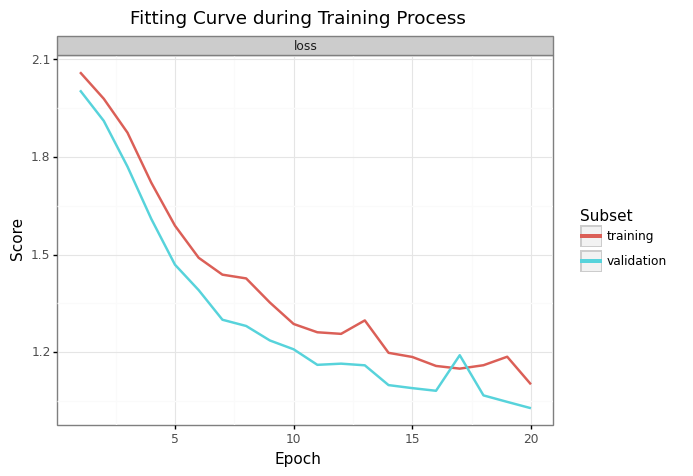

/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.fitting_course.accuracy.png


/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


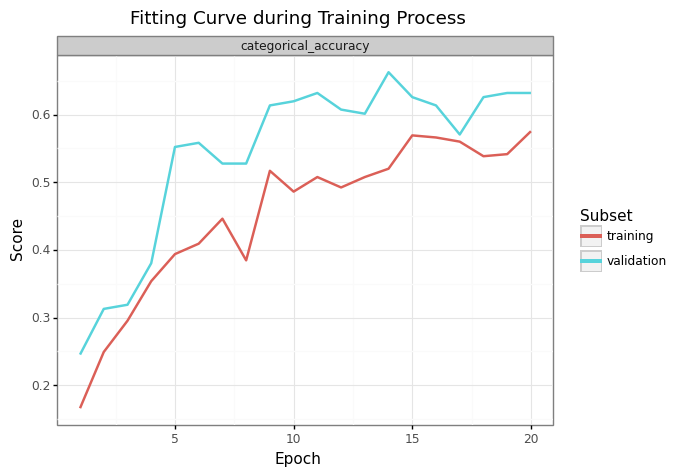

In [6]:
from aucmedi import *
from aucmedi.evaluation.fitting import *

evaluate_fitting(
    train_history = history,
    out_path = "./",
    monitor=["loss"],
    prefix_split=".",
    suffix="validation",
    show=True
)

evaluate_fitting(
    train_history = history,
    out_path = "./",
    monitor=["accuracy"],
    prefix_split=".",
    suffix="accuracy",
    show=True
)

Now we use the test-set to get some predictions from our model. We are going to compare the predictions of this model (were we augmented the training data) with the predictions of a model were we won't augment the training data later on.  
Note that we don't augment the test-data! The model is tested on the original test-data.

In [7]:
from aucmedi.data_processing import data_generator

predict_generator = data_generator.DataGenerator(samples=test[0], path_imagedir="data/Kather_texture_2016_image_tiles_5000",
                                                 resize=augmentation_model.meta_input, standardize_mode=augmentation_model.meta_standardize,
                                                 labels=None, image_format=image_format, batch_size=32, data_aug=None, 
                                                 shuffle=False, grayscale=False, subfunctions=[], prepare_images=False, 
                                                 sample_weights=None, seed=123, workers=1)



In [8]:
prediction_augmented_model = augmentation_model.predict(prediction_generator=predict_generator)

6/6 [==============================] - 1s 112ms/step


## Same model without augmentation

We are going to train the same model but without augmenting the training data, to see if there is a difference in the quality of the models predictions:

In [9]:
model = NeuralNetwork(n_labels=8, channels=3, loss="categorical_crossentropy", metrics=["categorical_accuracy", f1Score], activation_output="softmax")

train_generator = DataGenerator(samples=train[0], path_imagedir="data/Kather_texture_2016_image_tiles_5000",
                                               resize=model.meta_input, standardize_mode=model.meta_standardize,
                                               labels=train[1], image_format=image_format, batch_size=32, data_aug=None, 
                                               grayscale=False, subfunctions=[], prepare_images=False, 
                                               sample_weights=None, seed=123, workers=1)
val_generator = DataGenerator(samples=validation[0], path_imagedir="data/Kather_texture_2016_image_tiles_5000",
                                             resize=model.meta_input, standardize_mode=model.meta_standardize,
                                             labels=validation[1], image_format=image_format, batch_size=32, data_aug=None, 
                                             grayscale=False, subfunctions=[], prepare_images=False, 
                                             sample_weights=None, seed=123, workers=1)

history = model.train(training_generator=train_generator, validation_generator=val_generator, epochs=20, iterations=None, 
                                         callbacks=None, class_weights=None, transfer_learning=False)

Epoch 1/20
11/11 [==============================] - 3s 204ms/step - loss: 2.0590 - categorical_accuracy: 0.1477 - f1_score: 0.1932 - val_loss: 2.0114 - val_categorical_accuracy: 0.2086 - val_f1_score: 0.0000e+00
Epoch 2/20
11/11 [==============================] - 2s 189ms/step - loss: 1.9716 - categorical_accuracy: 0.2677 - f1_score: 0.0000e+00 - val_loss: 1.9109 - val_categorical_accuracy: 0.2638 - val_f1_score: 0.0000e+00
Epoch 3/20
11/11 [==============================] - 2s 156ms/step - loss: 1.8429 - categorical_accuracy: 0.3015 - f1_score: 0.0319 - val_loss: 1.7584 - val_categorical_accuracy: 0.3374 - val_f1_score: 0.0887
Epoch 4/20
11/11 [==============================] - 2s 174ms/step - loss: 1.6566 - categorical_accuracy: 0.3815 - f1_score: 0.1096 - val_loss: 1.5871 - val_categorical_accuracy: 0.4908 - val_f1_score: 0.1111
Epoch 5/20
11/11 [==============================] - 2s 171ms/step - loss: 1.5053 - categorical_accuracy: 0.4554 - f1_score: 0.1171 - val_loss: 1.4309 - val_

In [10]:
predict_generator = data_generator.DataGenerator(samples=test[0], path_imagedir="data/Kather_texture_2016_image_tiles_5000",
                                                 resize=model.meta_input, standardize_mode=model.meta_standardize,
                                                 labels=None, image_format=image_format, batch_size=32, data_aug=None, 
                                                 shuffle=False, grayscale=False, subfunctions=[], prepare_images=False, 
                                                 sample_weights=None, seed=123, workers=1)

prediction_model_without_augmentation = model.predict(prediction_generator=predict_generator)

6/6 [==============================] - 1s 106ms/step


## Compare the models

We can compare the predictions of both models (and their quality) with ``AUCMEDI``s ``evaluate_comparison`` function.

In [11]:
from aucmedi import *
from aucmedi.evaluation.comparison import *

pred_ensemble = [prediction_model_without_augmentation, prediction_augmented_model]

evaluate_comparison(pred_ensemble, test[1], out_path="./", class_names=class_names, model_names=["no_augmentation", "augmentation"], macro_average_classes=True)

/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 18 x 9 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.comparison.beside.png
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 18 x 9 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.comparison.gain.png
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(         metric            model       score
 0           AUC  no_augmentation    0.929663
 1      Accuracy  no_augmentation    0.907407
 2            F1  no_augmentation    0.618064
 3           FDR  no_augmentation    0.353690
 4            FN  no_augmentation    7.500000
 5           FNR  no_augmentation    0.367560
 6            FP  no_augmentation    7.500000
 7           FPR  no_augmentation    0.052917
 8     Precision  no_augmentation    0.646310
 9   Sensitivity  no_augmentation    0.632440
 10  Specificity  no_augmentation    0.947083
 11           TN  no_augmentation  134.250000
 12           TP  no_augmentation   12.750000
 13          AUC     augmentation    0.932418
 14     Accuracy     augmentation    0.918210
 15           F1     augmentation    0.651990
 16          FDR     augmentation    0.331889
 17           FN     augmentation    6.625000
 18          FNR     augmentation    0.324405
 19           FP     augmentation    6.625000
 20          FPR     augmentation 

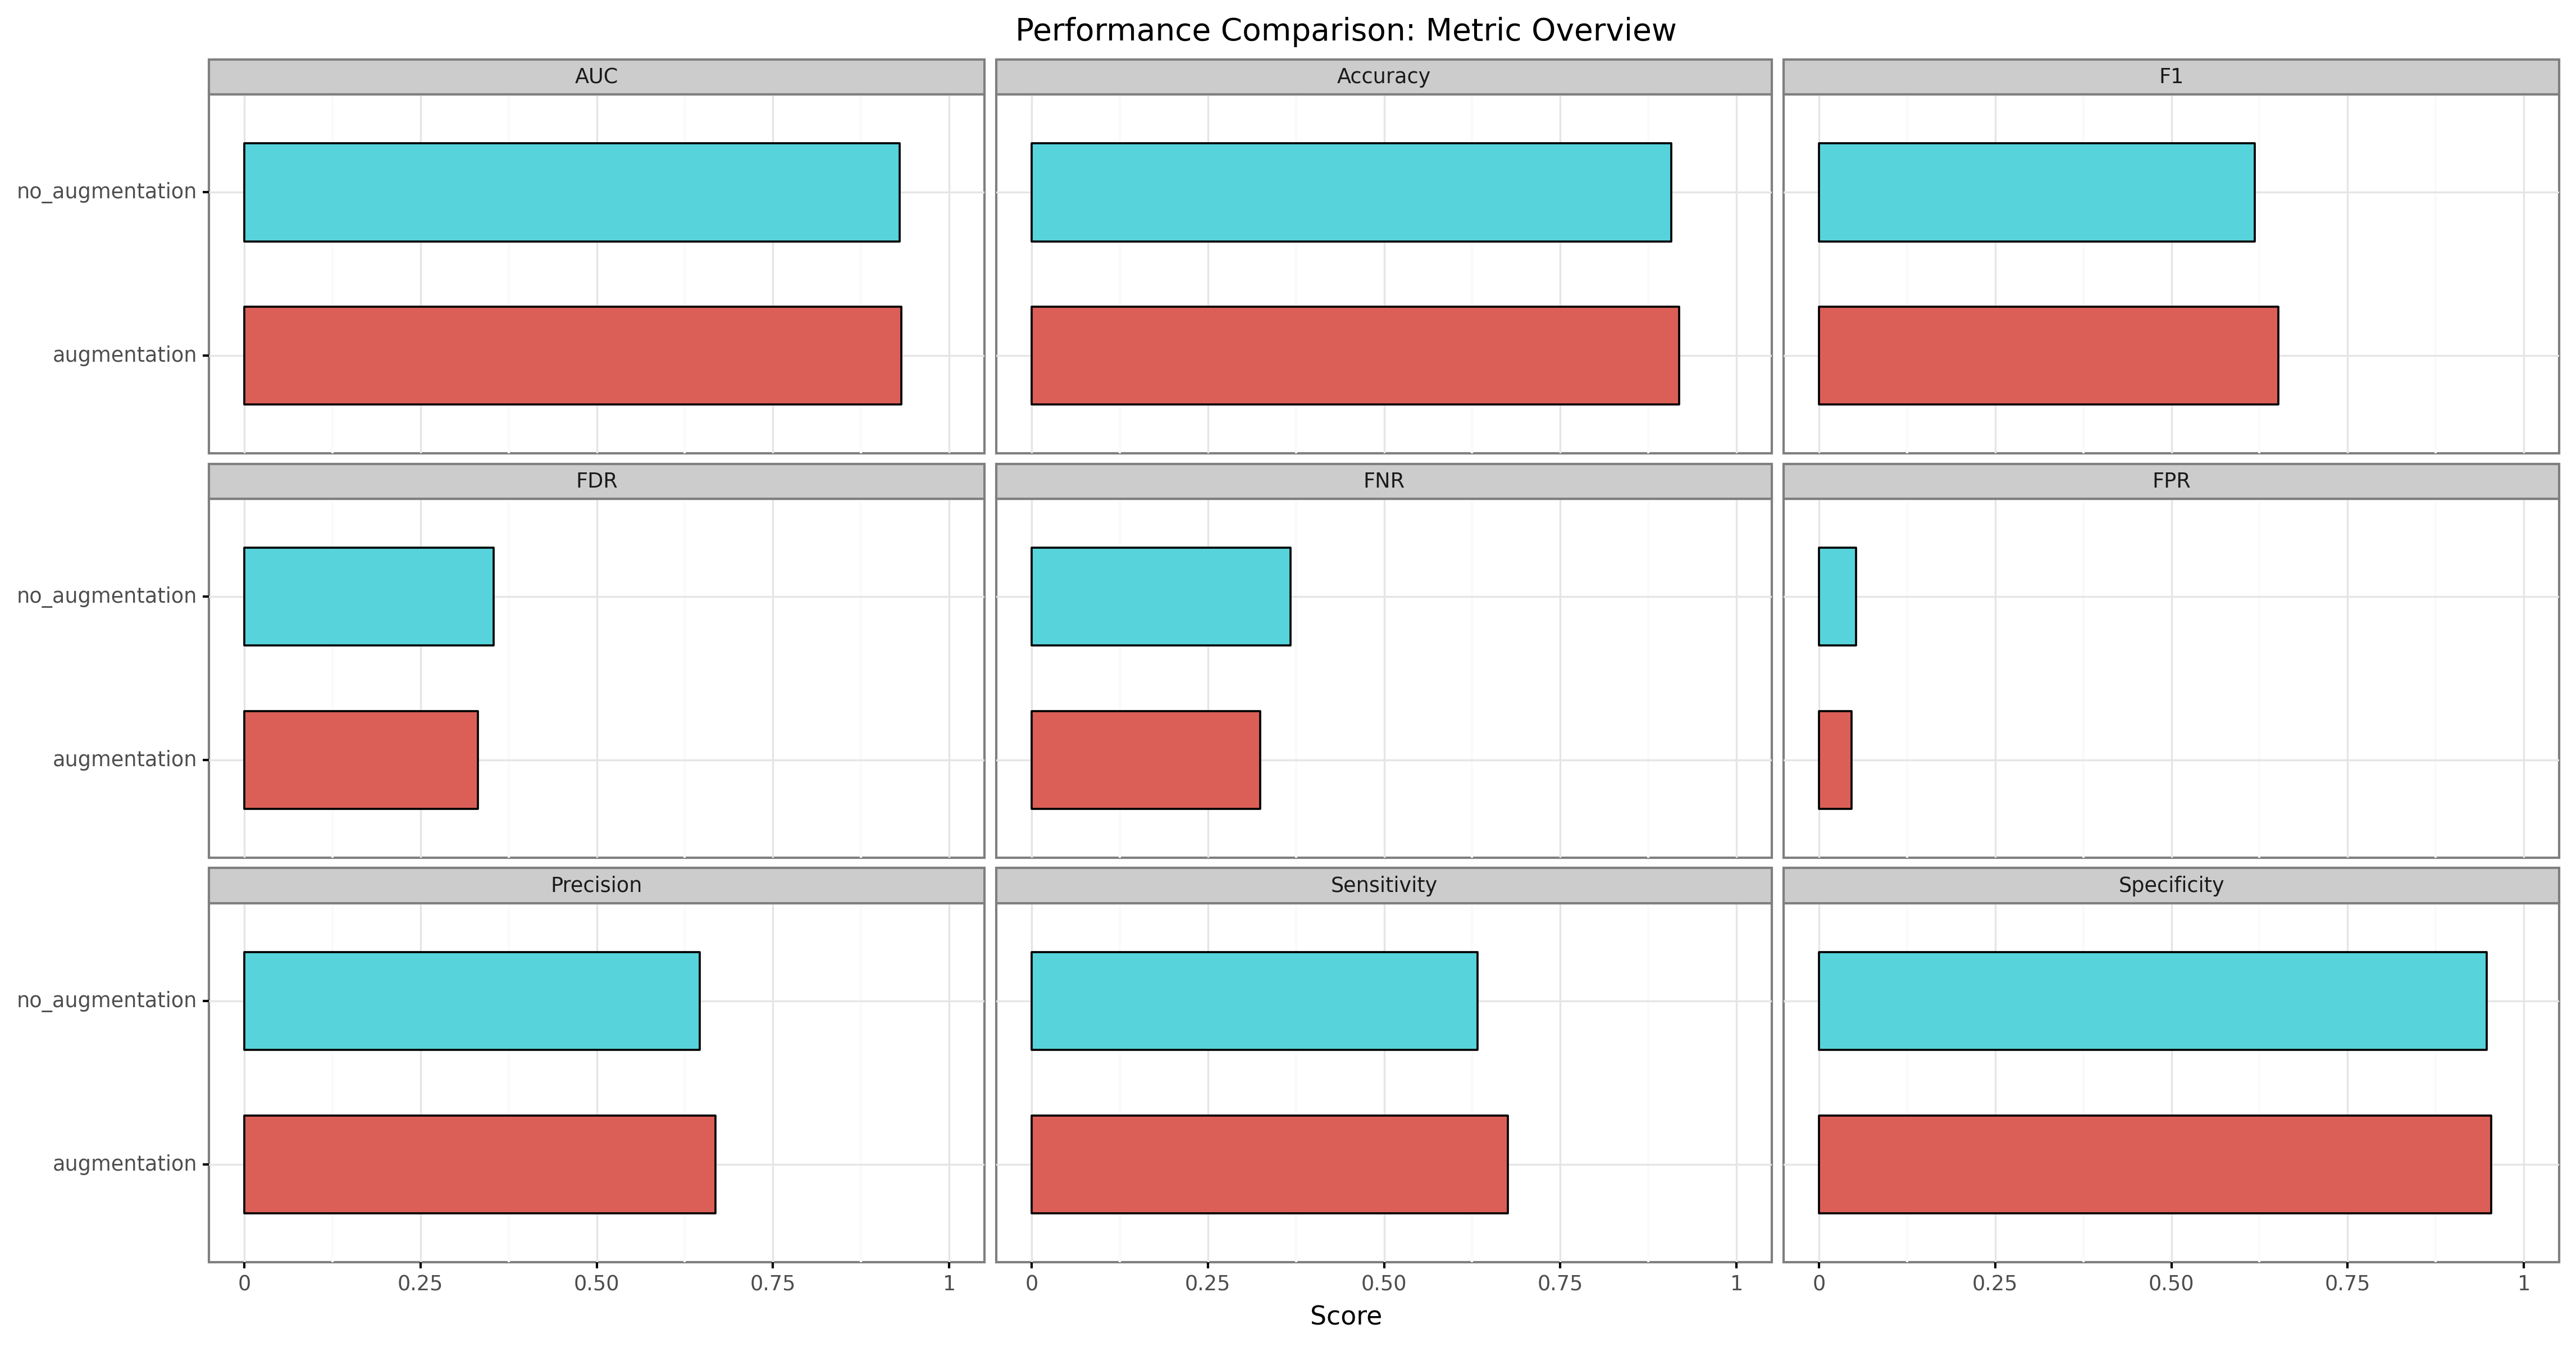

In [12]:
from PIL import Image
img = Image.open("plot.comparison.beside.png")
img.show()

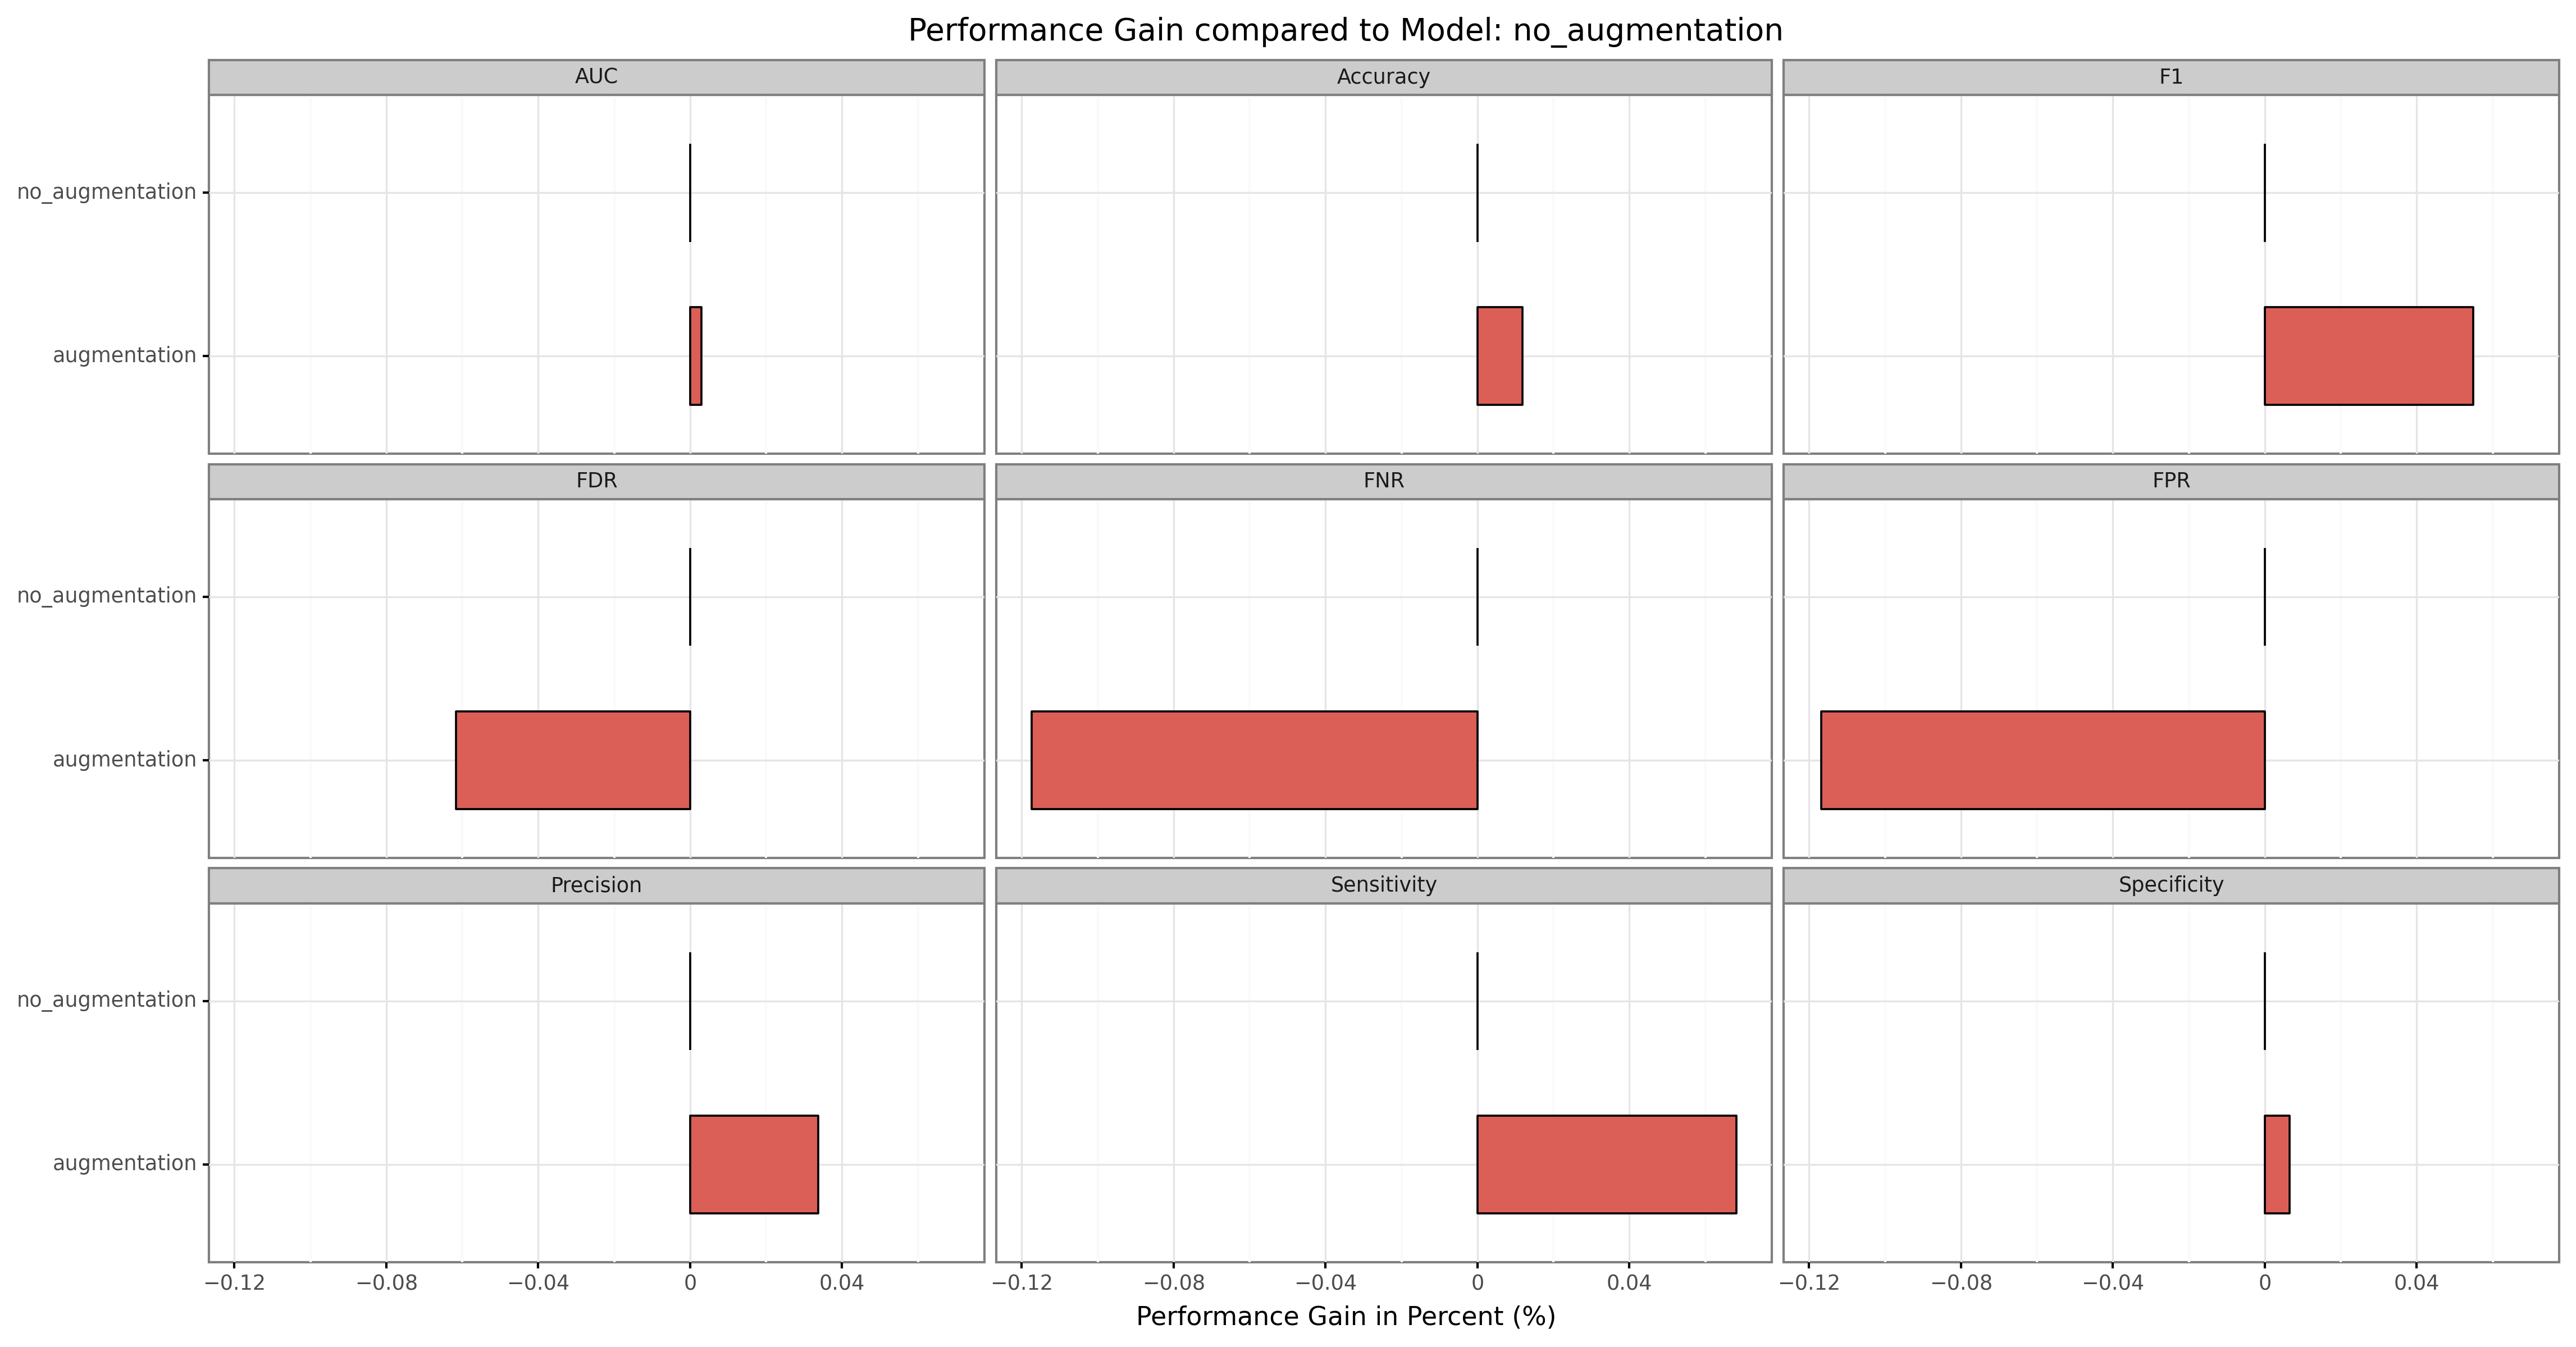

In [13]:
from PIL import Image
img = Image.open("plot.comparison.gain.png")
img.show()

As we can see, the model with augmentation performed slightly better. These are pretty simple data, which are easy to learn even without augmentation. For more complicated data the benefit of augmentation should be more obvious.